# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# HOMEWORK 1 - Supervised Deep Learning - Notebook 1/2

**FRANCESCO FONTANA -  matricola 2026924**

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). The report must be self-contained, so please make sure that all relevant results are explicitly included in the report / notebook.




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook or source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import csv
from scipy.stats import loguniform
from sklearn.model_selection import KFold
import os

In [ ]:
#Creating directory for storing images and graphs
if os.path.isdir("report")== False:
  os.mkdir("report")
if os.path.isdir("report/reg_imgs")== False:
  os.mkdir("report/reg_imgs")

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-07-03 14:27:27--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-07-03 14:27:29 (69.9 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-07-03 14:27:29--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

How to load the data:

In [ ]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

How to get a specific sample:

In [ ]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

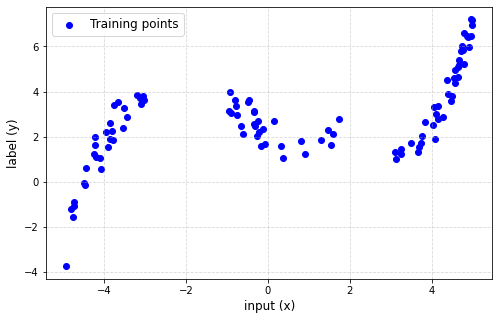

In [ ]:
size = 12
fig = plt.figure(figsize=(8,5))
plt.scatter(train_df.input, train_df.label, label='Training points', color="blue")
plt.xlabel('input (x)', size = size)
plt.ylabel('label (y)', size = size)
plt.legend(fontsize = size)
plt.grid(linestyle = "--", alpha = 0.5)
plt.show()

fig.savefig("report/default_example_reg.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, Nh3, No, activation = "Sigmoid", drop_p = 0):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        Nh3 - Neurons in the 3rd hidden layer
        No - Output size
        """
        super().__init__()
        
        #print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        if activation == "Sigmoid": self.act = nn.Sigmoid()
        elif activation == "Tanh": self.act = nn.Tanh()
        elif activation == "ReLU": self.act = nn.ReLU()
        elif activation == "LeakyReLU": self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x, additional_out=False, stop1 = False, stop2 = False, stop3 = False):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        if stop1: return x
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        if stop2: return x
        x = self.act(self.fc3(x))
        x = self.dropout(x)
        if stop3: return x
        x = self.out(x)
        return x

In [ ]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, "r") as f:
                header = f.readline()
                lines = f.read()
        self.data = [tuple(map(float, line.split(","))) for line in lines.split("\n")[:100]]

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [ ]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)
#dataset = ConcatDataset([train_dataset,val_dataset])

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
def train_epoch(net, train_dataloader, loss_fn, optimizer):
    train_loss = []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
        
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    return train_loss
    #print(f"AVERAGE TRAIN LOSS: {train_loss}")

In [ ]:
def test_epoch(net, val_dataloader, loss_fn):
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    return np.mean(val_loss)



In [ ]:
def random_hyperparameters():

    regularization_type = np.random.choice(['none', 'l2', 'dropout'])
    regularization_strength = 0.
    
    if regularization_type == 'l2': regularization_strength = loguniform.rvs(1e-5, 1e-1)
    elif regularization_type == 'dropout': regularization_strength = loguniform.rvs(1e-4, 1e-1)

    hyperparameters = {
        'n_epochs': 150,
        'Nh1': 10,
        'Nh2': 15,
        'Nh3': 10,
        'batch_size': np.random.choice([4, 8, 10, 12]).tolist(),
        'activation' : np.random.choice(['ReLU', 'Tanh', 'Sigmoid', 'LeakyReLU']),
        'lr': loguniform.rvs(1e-4, 1e-1),
        'regularization_type' : regularization_type,
        'regularization_strength' : regularization_strength,
        'l2': regularization_strength if regularization_type == 'l2' else 0.,
        'opt' : np.random.choice(['Adam', 'RMSprop', 'SGD']),
        'dropout': regularization_strength if regularization_type == 'dropout' else 0.
    }
    return hyperparameters

# Random search

## Cross Validation

In [ ]:
def training_loop_cv_1(train_dataset, params, nfolds = 5):
    Ni = 1
    Nh1 = params["Nh1"]
    Nh2 = params["Nh2"]
    Nh3 = params["Nh3"]
    No = 1
    net = Net(Ni, Nh1, Nh2, Nh3, No, params["activation"], drop_p = params['dropout'])
    net.to(device)

    # Define the K-fold Cross Validator
    num_folds = nfolds
    kfold = KFold(n_splits=num_folds, shuffle=True)

    num_epochs  = params["n_epochs"]
    
    train_log_folds = np.zeros((num_folds, num_epochs))
    val_log_folds   = np.zeros((num_folds, num_epochs))

    for f, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        #print('####################################################################')
        #print(f'# FOLD {f+1}')
        #print('####################################################################\n')

        train_subsampler = SubsetRandomSampler(train_idx)
        val_subsampler   = SubsetRandomSampler(val_idx)
        
        train_dataloader = DataLoader(train_dataset, batch_size=params["batch_size"], sampler=train_subsampler)
        val_dataloader   = DataLoader(train_dataset, batch_size=params["batch_size"], sampler=val_subsampler)
        
        # Define the loss function
        loss_fn = nn.MSELoss()

        # Define the optimizer
        if   params["opt"] == "Adam":    optimizer = optim.Adam(net.parameters(),     lr = params["lr"], weight_decay= params["l2"])
        elif params["opt"] == "RMSprop": optimizer = optim.RMSprop(net.parameters(),  lr = params["lr"], weight_decay= params["l2"])
        elif params["opt"] == "SGD":     optimizer = optim.SGD(net.parameters(),      lr = params["lr"], weight_decay= params["l2"])

        train_loss_log = np.zeros(num_epochs)
        val_loss_log = np.zeros(num_epochs)

        for epoch_num in range(num_epochs):
            train_loss = train_epoch(net, train_dataloader, loss_fn, optimizer)
            train_loss_log[epoch_num] = train_loss

            val_loss = test_epoch(net, val_dataloader, loss_fn)
            val_loss_log[epoch_num] = val_loss
        
        train_log_folds[f] = train_loss_log
        val_log_folds[f]   = val_loss_log
        
    return np.mean(train_log_folds, axis = 0), np.mean(val_log_folds, axis = 0), net

In [ ]:
niter = 300
rgs_df = pd.DataFrame(columns = ["Nh1", "Nh2", "Nh3", "batch_size", "activation", "lr", "regularization_type"
                            , "regularization_strength", "l2", "opt", 'dropout', "mean_train_loss", "mean_val_loss"], index = range(1,niter+1))


for it in range(1, niter+1):
    print("Executing random-grid search {}/300".format(it))
    r_params = random_hyperparameters()
    rgs_df.loc[it] = r_params
    loss, val, _ = training_loop_cv_1(train_dataset, r_params)
    rgs_df.loc[it, "mean_train_loss"] = np.mean(loss, dtype = np.float32)
    rgs_df.loc[it, "mean_val_loss"] = np.mean(val, dtype = np.float32)
    

rgs_df

In [ ]:
rgs_df = rgs_df.astype({"mean_val_loss":float})

#df.to_pickle("./random_grid_search_reg.pkl") # ----saving dataframe random grid search

#df=pd.read_pickle("./random_grid_search_reg.pkl") # ----loading dataframe random grid search
best_res = rgs_df.nsmallest(10, 'mean_val_loss')
best_res

In [ ]:
#Hyperparameter corresponding to the best result for random grid-search
#best_res.iloc[0]

# Single training with parameters found during random search

In [ ]:
hyperparameters = {
        'n_epochs': 500,
        'Nh1': 10,
        'Nh2': 15,
        'Nh3': 10,
        'batch_size': 10,
        'activation' : "LeakyReLU",
        'lr': 0.008,
        'opt' : "Adam",
        'loss': 'MSELoss',
        'l2': 0.0002,
        'dropout': 0.005
    }

In [ ]:
final_loss, final_val, net = training_loop_cv_1(train_dataset, hyperparameters)

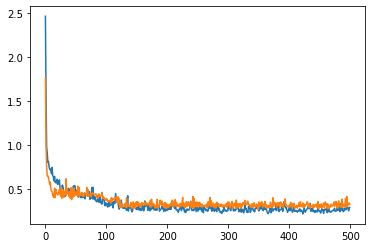

In [ ]:
plt.plot(final_loss)
plt.plot(final_val)

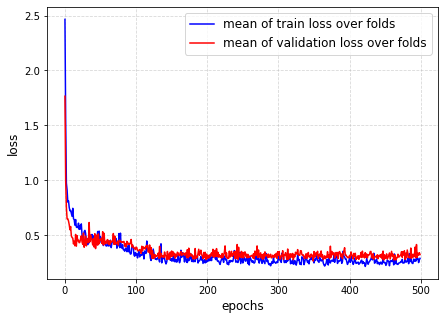

In [ ]:
#train_folds_mean = np.mean(train_folds, axis = 0)
#val_folds_mean = np.mean(val_folds, axis = 0)

size = 12
fig = plt.figure(figsize = (7,5))
plt.plot(final_loss, color = "blue", label = "mean of train loss over folds")
plt.plot(final_val, color = "red", label = "mean of validation loss over folds")
plt.xlabel("epochs", fontsize = size)
plt.ylabel("loss", fontsize = size)
plt.legend(fontsize = size)
plt.grid(linestyle = "--", alpha = 0.5)
plt.show()
fig.savefig("report/reg_training.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

In [ ]:
# Input vector
x_vec = torch.linspace(-5,5,10000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout 
# BatchNorm etc. 
net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

Input shape: torch.Size([10000, 1])
Output shape: torch.Size([10000, 1])


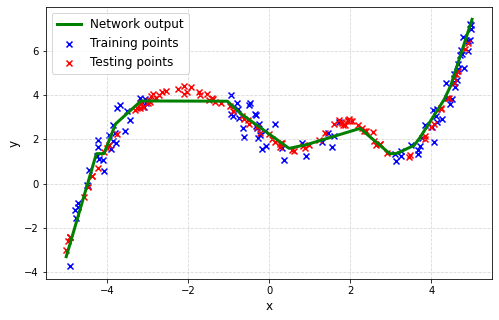

In [ ]:
# Plot output
fig = plt.figure(figsize=(8,5))
plt.scatter(train_df.input, train_df.label, label='Training points',color="blue", marker="x", linewidths=2 )
plt.scatter(test_df.input, test_df.label, label='Testing points', color="red", marker="x", linewidths=2)
plt.plot(x_vec, y_vec, label='Network output', color = "green", linewidth=3)
plt.xlabel('x', size = size)
plt.ylabel('y', size = size)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = size)
plt.show()
fig.savefig("report/network_out.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

In [ ]:
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

In [ ]:
test_loss = []
loss_fn = nn.MSELoss()
net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        test_loss.append(loss_batch)

test_loss
#test_epoch(net1, test_dataloader, loss_fn)

[array(0.09435324, dtype=float32)]

In [ ]:
net1=net #copy of net
net1

Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.005, inplace=False)
)

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
network_state_dict = net1.state_dict()
print(network_state_dict.keys())
# Save the state dict to a file
torch.save(network_state_dict, './regression_dataset/network_parameters.torch')

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'out.weight', 'out.bias'])


In [ ]:
### Reload the network state

reload = False
# First initialize the network (if not already done)
# IMPORTANT: you need to know the model definition!!
if reload:
  net2 = Net(1, 10, 15, 10, 1) 
  # Load the state dict previously saved
  network_state_dict = torch.load('./regression_dataset/network_parameters.torch', map_location=torch.device('cuda:0'))
  # Update the network parameters
  net.load_state_dict(network_state_dict)
  net.to(device)

In [ ]:
# Input vector
x_vec = torch.linspace(-5,5,10000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout 
# BatchNorm etc. 
net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

Input shape: torch.Size([10000, 1])
Output shape: torch.Size([10000, 1])


In [ ]:
# Showing activation profile for the hidden layers

rangex = torch.linspace(-5,5,10000)
rangex = rangex.to(device)
rangex = rangex.unsqueeze(-1) # Adding a dimension to the input vector

log1 =np.zeros((10,1))
log2 =np.zeros((15,1))
log3 =np.zeros((10,1))
log4= np.zeros(1)

net.eval()
with torch.no_grad(): 
    for Nh in range(4):
            
            if   Nh==0:
              act1 = net(rangex, stop1= True)
              act1 = act1.squeeze().cpu().numpy()
              log1 =act1

            elif Nh==1:
              act2 = net(rangex, stop2= True)
              act2 = act2.squeeze().cpu().numpy()
              log2 =act2

            elif Nh==2:
              act3 = net(rangex, stop3= True)
              act3 = act3.squeeze().cpu().numpy()
              log3 =act3

            else:
              out = net(rangex)
              out = out.squeeze().cpu().numpy()
              log4 = out


rangex = rangex.squeeze().cpu().numpy()

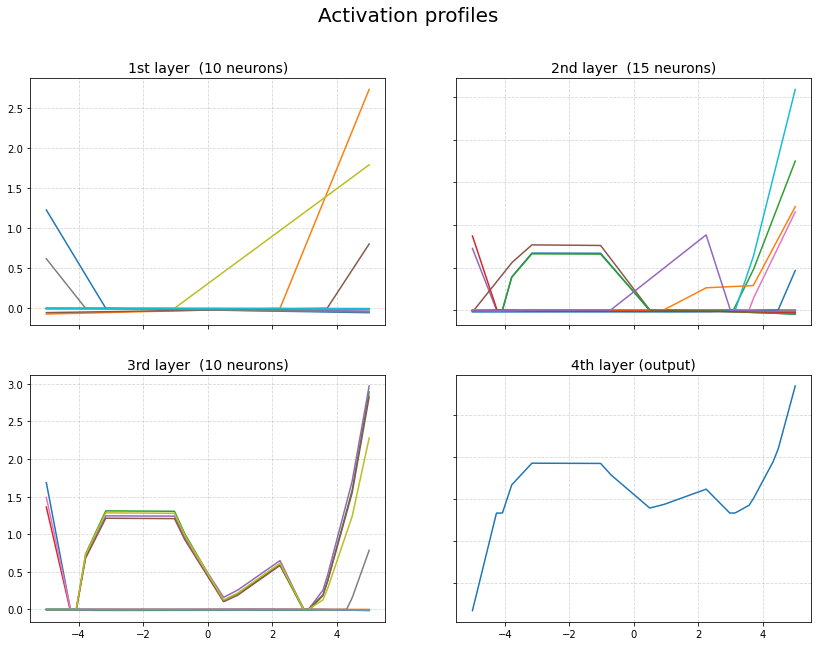

In [ ]:
from IPython.core.pylabtools import figsize

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(14,10),)
fig.suptitle('Activation profiles',size=20)

#-----ACTIVATION PROFILE 1 -----
df=pd.DataFrame(log1)
for i in df.columns:
    ax1.plot(rangex,df.iloc[:,i]) #, linefmt="green")
    ax1.set_title("1st layer  (10 neurons)",size=14)

#-----ACTIVATION PROFILE 2 -----
df=pd.DataFrame(log2)
for i in df.columns:
    ax2.plot(rangex,df.iloc[:,i]) #, linefmt="green")
    ax2.set_title("2nd layer  (15 neurons)",size=14)

  #-----ACTIVATION PROFILE 3 -----
df=pd.DataFrame(log3)
for i in df.columns:
    ax3.plot(rangex,df.iloc[:,i]) #, linefmt="green")
    ax3.set_title("3rd layer  (10 neurons)",size=14)

  #-----ACTIVATION PROFILE 4 -----
df=pd.DataFrame(log4)
for i in df.columns:
    ax4.plot(rangex,df.iloc[:,i]) #, linefmt="green")
    ax4.set_title("4th layer (output)", size=14)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle = "--",alpha=0.5)


fig.savefig("./report/activation_profiles_reg.pdf", transparent = True, bbox_inches = "tight", pad_inches = 0)

In [ ]:
sample = DataLoader(test_dataset, batch_size=1, shuffle=True) 
x_batch=None
with torch.no_grad(): 

    for sample_batched in (sample):
        x_batch = sample_batched[0].to(device)
        out = net(x_batch,stop1= True)
        out1 = out.squeeze().cpu().numpy()
        break
    for sample_batched in (sample):
        x_batch = sample_batched[0].to(device)
        out = net(x_batch,stop2= True)
        out2 = out.squeeze().cpu().numpy()
        break
    for sample_batched in (sample):
        x_batch = sample_batched[0].to(device)
        out = net(x_batch,stop3= True)
        out3 = out.squeeze().cpu().numpy()
        break

Activation of hidden layers for input x = 4.05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this war

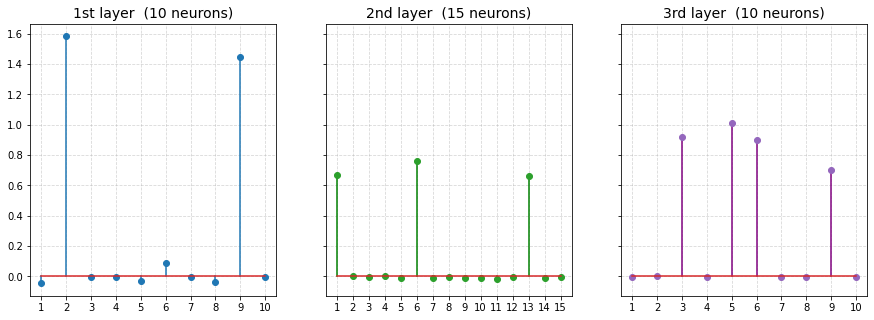

In [ ]:
from IPython.core.pylabtools import figsize
print( sample)
fig, ((ax1,ax2,ax3)) = plt.subplots(1, 3, figsize=(15,5),sharey=True)
#fig.suptitle("Activation of hidden layers for input x = %.2f"%x_batch[0],y=1.05, size=18)
print("Activation of hidden layers for input x = %.2f"%x_batch[0])

#-----ACTIVATION layer 1 -----
ax1.stem(range(1,11),out1,  markerfmt='C0o' ) 
ax1.set_xticks(range(1,11))
#ax1.set_xlabel("Neuron number")
ax1.set_title("1st layer  (10 neurons)",size=14)

#-----ACTIVATION layer 2 -----
ax2.stem(range(1,16), out2, linefmt="green", markerfmt='C2o' )
ax2.set_xticks(range(1,16))
#ax2.set_xlabel("Neuron number")
ax2.set_title("2nd layer  (15 neurons)",size=14)

#-----ACTIVATION layer 3 -----
ax3.stem(range(1,11), out3 , linefmt="purple",markerfmt='C4o' )
ax3.set_xticks(range(1,11))
#ax3.set_xlabel("Neuron number")
ax3.set_title("3rd layer  (10 neurons)",size=14)


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle = "--",alpha=0.5)


fig.savefig("./report/act_layers_reg.pdf", transparent = True, bbox_inches = "tight", pad_inches = 0)

In [ ]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy() 
h1_b = net.fc1.bias.data.cpu().numpy() 

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Third hidden layer
h3_w = net.fc3.weight.data.cpu().numpy()
h3_b = net.fc3.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy() 
out_b = net.out.bias.data.cpu().numpy()

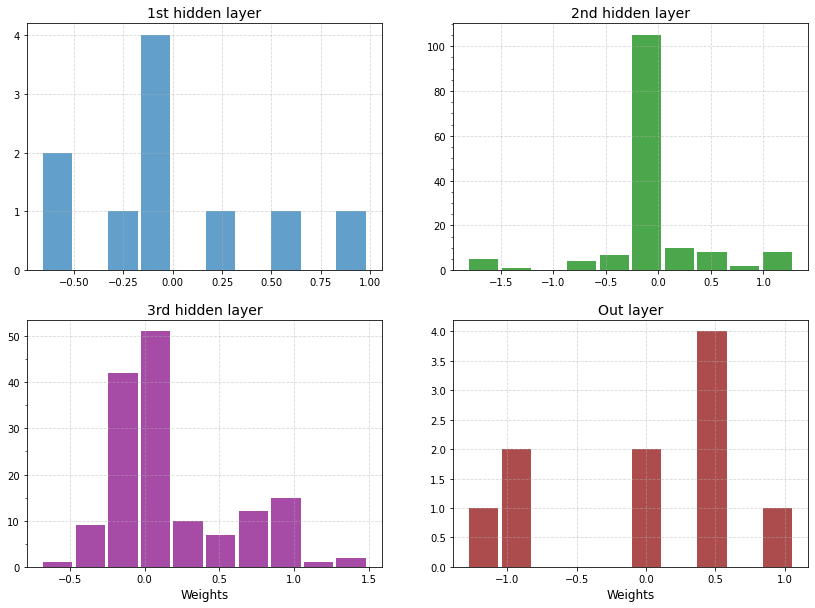

In [ ]:
from IPython.core.pylabtools import figsize

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(14,10),)

#-----HISTOGRAM WEIGHT LAYER 1 -----
ax1.hist(h1_w.flatten(), fill = True, alpha = 0.7, rwidth=0.9)
ax1.set_yticks(range(0,5))
ax1.set_title("1st hidden layer", size = 14)

#-----HISTOGRAM WEIGHT LAYER 2 -----
ax2.hist(h2_w.flatten(), color = "green", fill = True, alpha = 0.7, rwidth=0.9,)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.set_title("2nd hidden layer", size = 14)

#-----HISTOGRAM WEIGHT LAYER 1 -----
ax3.hist(h3_w.flatten(), color = "purple", fill = True, alpha = 0.7,rwidth=0.9,)
ax3.yaxis.set_minor_locator(MultipleLocator(5))
ax3.set_title("3rd hidden layer", size = 14)
ax3.set_xlabel("Weights", size =12)

#-----HISTOGRAM WEIGHT LAYER 4 -----
ax4.hist(out_w.flatten(), color = "darkred", fill = True, alpha = 0.7, rwidth=0.9,)
ax4.set_title("Out layer", size = 14)
ax4.set_xlabel("Weights", size =12)


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():

    #ax.label_outer()
    ax.grid( linestyle = "--",alpha=0.5)

fig.savefig("./report/all_hists_reg.pdf", transparent = True, bbox_inches = "tight", pad_inches = 0)